# Sentiment Analysis in Python

This notebook is part of a tutorial that can be found on my [youtube channel here](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw), please check it out!

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [3]:
# Read in data
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
print(df.shape)

df = df.head(500)  # Use only first 500
print(df.shape)

(568454, 10)
(500, 10)


In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Quick EDA

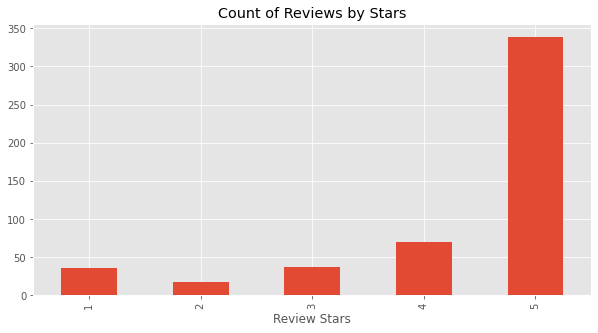

In [6]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar',
                                                  title='Count of Reviews by Stars',
                                                  figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [7]:
# Print contents of a random review
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [8]:
# Tokenize it (prepare a list of tokens; each word and grammar symbol is a token)
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('I am so happy!')

In [ ]:
sia.polarity_scores('This is the worst thing ever.')

In [ ]:
sia.polarity_scores(example)

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
# Now we have sentiment score and metadata
vaders.head()

## Plot VADER results

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [ ]:
results_df.columns

# Step 3. Combine and compare

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [ ]:
# nevative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline('I love sentiment analysis!')

In [ ]:
sent_pipeline('Make sure to like and subscribe!')

In [ ]:
sent_pipeline('booo')

# The End